# Analyzing SEC EDGAR Filing Trends and Patterns with FinFeedAPI

## Introduction

Filings submitted to the U.S. Securities and Exchange Commission (SEC) are a crucial source of information for investors, analysts, and researchers. They contain detailed data about the financial situation, operations, and management of public companies. However, analyzing this data at scale can be challenging due to its volume and diverse formats.

This notebook demonstrates how to use **FinFeedAPI** (your custom API provided by API BRICKS LTD) to programmatically access and analyze SEC filing data. We will focus on:

1.  **Fetching Filing Metadata:** Utilizing the `/v1/filings` endpoint to filter and retrieve information about filings based on criteria like CIK, form type, dates, etc.
2.  **Analyzing Time Trends:** Investigating how the number of filings has changed over a specific period.
3.  **Analyzing Form Types:** Identifying the most commonly submitted form types within our retrieved data.
4.  **Content Extraction:** Demonstrating how to access the structured content of specific filings using the `/v1/extractor` and `/v1/extractor/item` endpoints.
5.  **Full-Text Search:** Showing how to leverage the `/v1/full-text` endpoint to search for keywords within filing documents.

**Note:** The analysis in this notebook will primarily rely on the metadata available through the `/v1/filings` endpoint for trend analysis. Fetching and analyzing the *content* of filings at a large scale using `/v1/extractor` would require more extensive coding, potentially involving handling large text data and NLP techniques.

## Environment Setup

First, let's import the necessary Python libraries and configure the basic API parameters.

In [ ]:
pip install api-bricks-sec-api-rest

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.6/50.6 kB 1.4 MB/s eta 0:00:00


In [ ]:
# Import necessary libraries
import requests
import pandas as pd
import matplotlib.pyplot as plt
import json
from datetime import datetime
import os # To potentially load the API key from an environment variable
from IPython.display import display # For better DataFrame display in Jupyter
import api_bricks_sec_api_rest

# --- API Configuration ---
# !!! IMPORTANT: Insert your API Key below !!!
# You can also load it from an environment variable for better security
# e.g., API_KEY = os.getenv('FINFEED_API_KEY')
API_KEY = "YOUR_API_KEY_HERE"  # <--- REPLACE THIS WITH YOUR ACTUAL KEY!
api_client = api_bricks_sec_api_rest.ApiClient(header_name="Authorization", header_value=API_KEY)

# --- Plotting Configuration ---
try:
    # Use a modern seaborn style if available
    plt.style.use('seaborn-v0_8-darkgrid')
except OSError:
    # Fallback to default style if seaborn style is not found
    print("Seaborn style 'seaborn-v0_8-darkgrid' not found, using default.")
    plt.style.use('default')
# Set default figure size for plots
plt.rcParams['figure.figsize'] = (12, 6)

## 1. Fetching Filing Metadata (`/v1/filings`)

The `/v1/filings` endpoint allows querying SEC filing metadata. You can filter by various criteria as defined in the OpenAPI spec, including:

* `cik`: Central Index Key
* `form_type`: e.g., "10-K", "8-K", "10-Q" (comma-separated for multiple)
* `filling_date_start` / `filling_date_end`: Filing date range (YYYY-MM-DD)
* `report_date_start` / `report_date_end`: Report date range (YYYY-MM-DD)
* `items_contain`: Text search within the 'items' field
* Pagination: `page_size` (max 200), `page_number`
* Sorting: `sort_by` (e.g., FilingDate, Size), `sort_order` (asc, desc)

**Example:** Let's fetch all metadata for the recent Form 8-K filings submitted in the first quarter of 2024.

In [ ]:
from api_bricks_sec_api_rest.rest import ApiException

# Define parameters for the API call
start_date_q1_2024 = "2024-01-01"
end_date_q1_2024 = "2024-03-31"
target_form_type = "8-K"
results_limit = 200  # Maximum results per page (API limit)

api_instance = api_bricks_sec_api_rest.FilingMetadataApi(api_client)
all_metadata = []  # List to store all fetched metadata

page_number = 1  # Start with the first page
while True:
    print(f"Fetching metadata for {target_form_type} filings (page {page_number})...")

    try:
      metadata_list = api_instance.v1_filings_get (
          form_type = target_form_type,
          filling_date_start = start_date_q1_2024,
          filling_date_end = end_date_q1_2024,
          page_size = results_limit,
          page_number= page_number
      )
      if metadata_list is not None and isinstance(metadata_list, list):
          print(f"  Fetched {len(metadata_list)} records on page {page_number}.")
          all_metadata.extend(metadata_list)  # Add this page's data to the main list

          # Check if this was the last page
          if len(metadata_list) < results_limit:
              print("  Last page reached.")
              break  # Exit the loop if this was the last page
          else:
              page_number += 1  # Move to the next page
      else:
          print(f"  Error or empty result on page {page_number}. Stopping fetch.")
          break  # Exit the loop if there's an error or empty result
    except ApiException as e:
        print("Exception when calling FilingMetadataApi->v1_filings_get: %s\n" % e)

# Create DataFrame after fetching all data
filings_df = pd.DataFrame.from_records([vars(x) for x in all_metadata])

# ... (Rest of the code for data processing and visualization) ...
print("\nFirst 5 records:")
display(filings_df.head()) # Use display() for better rendering in Jupyter

print("\Basic Info DataFrame:")
filings_df.info()

print("\nFilings DataFrame description:")
filings_df.describe()

Fetching metadata for 8-K filings (page 1)...
  Fetched 200 records on page 1.
Fetching metadata for 8-K filings (page 2)...
  Fetched 200 records on page 2.
Fetching metadata for 8-K filings (page 3)...
  Fetched 200 records on page 3.
Fetching metadata for 8-K filings (page 4)...
  Fetched 200 records on page 4.
Fetching metadata for 8-K filings (page 5)...
  Fetched 200 records on page 5.
Fetching metadata for 8-K filings (page 6)...
  Fetched 200 records on page 6.
Fetching metadata for 8-K filings (page 7)...
  Fetched 200 records on page 7.
Fetching metadata for 8-K filings (page 8)...
  Fetched 200 records on page 8.
Fetching metadata for 8-K filings (page 9)...
  Fetched 200 records on page 9.
Fetching metadata for 8-K filings (page 10)...
  Fetched 200 records on page 10.
Fetching metadata for 8-K filings (page 11)...
  Fetched 200 records on page 11.
Fetching metadata for 8-K filings (page 12)...
  Fetched 200 records on page 12.
Fetching metadata for 8-K filings (page 13)...

,cik,accession_number,filing_date,report_date,acceptance_date_time,act,form,file_number,film_number,items,core_type,size,is_xbrl,is_inline_xbrl,primary_document,primary_doc_description,source_file
0,1750,0001104659-24-002165,2024-01-08,2024-01-08,2024-01-08 00:00:00+00:00,34,8-K,001-06263,24519598,"7.01,9.01",None,295072,True,True,None,FORM 8-K,https://www.sec.gov/Archives/edgar/data/1750/0...
1,1750,0001104659-24-023011,2024-02-14,2024-02-14,2024-02-14 00:00:00+00:00,34,8-K,001-06263,24632862,"8.01,9.01",None,2630173,True,True,None,FORM 8-K,https://www.sec.gov/Archives/edgar/data/1750/0...
2,1750,0001104659-24-029986,2024-03-01,2024-03-01,2024-03-01 00:00:00+00:00,34,8-K,001-06263,24710026,"1.01,2.01,2.03,7.01,8.01,9.01",None,3362557,True,True,None,FORM 8-K,https://www.sec.gov/Archives/edgar/data/1750/0...
3,1750,0001104659-24-036764,2024-03-20,2024-03-19,2024-03-20 00:00:00+00:00,34,8-K,001-06263,24768472,"5.02,9.01",None,440418,True,True,None,FORM 8-K,https://www.sec.gov/Archives/edgar/data/1750/0...
4,1750,0001104659-24-037286,2024-03-21,2024-03-21,2024-03-21 00:00:00+00:00,34,8-K,001-06263,24771485,"2.02,9.01",None,608156,True,True,None,FORM 8-K,https://www.sec.gov/Archives/edgar/data/1750/0...


\Basic Info DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16997 entries, 0 to 16996
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype              
---  ------                   --------------  -----              
 0   cik                      16997 non-null  int64              
 1   accession_number         16997 non-null  object             
 2   filing_date              16997 non-null  object             
 3   report_date              16997 non-null  object             
 4   acceptance_date_time     16997 non-null  datetime64[ns, UTC]
 5   act                      16997 non-null  object             
 6   form                     16997 non-null  object             
 7   file_number              16997 non-null  object             
 8   film_number              16996 non-null  object             
 9   items                    16997 non-null  object             
 10  core_type                0 non-null      object             
 11  size 

,cik,size
count,1.699700e+04,1.699700e+04
mean,1.309395e+06,1.635512e+06
std,5.200488e+05,5.318228e+06
min,1.750000e+03,2.549000e+03
25%,1.013237e+06,2.038070e+05
50%,1.490161e+06,3.010550e+05
75%,1.729944e+06,7.921930e+05
max,1.953984e+06,1.281441e+08


**Note on Fetching Comprehensive Historical Data:**

To replicate the analysis over many years (like 1994-2022 in the `sec-api.io` example), you would need to make multiple API calls, iterating through time periods (e.g., year by year) and handling pagination within each period. The `/v1/filings` endpoint has a `page_size` limit (max 200). If a period has more filings than the `page_size`, you'll need to request subsequent pages (`page_number=2`, `page_number=3`, ...) until you receive fewer results than the `page_size` or an empty list.

## 2. Data Analysis and Visualization

Now, let's perform some basic analysis and visualization on the `filings_df` DataFrame we fetched (even if it's just a sample from Q1 2024).

### 2.1. Filing Counts Over Time (Monthly for Q1 2024)

Since we fetched data for Q1 2024, we can visualize the monthly filing counts within this period.


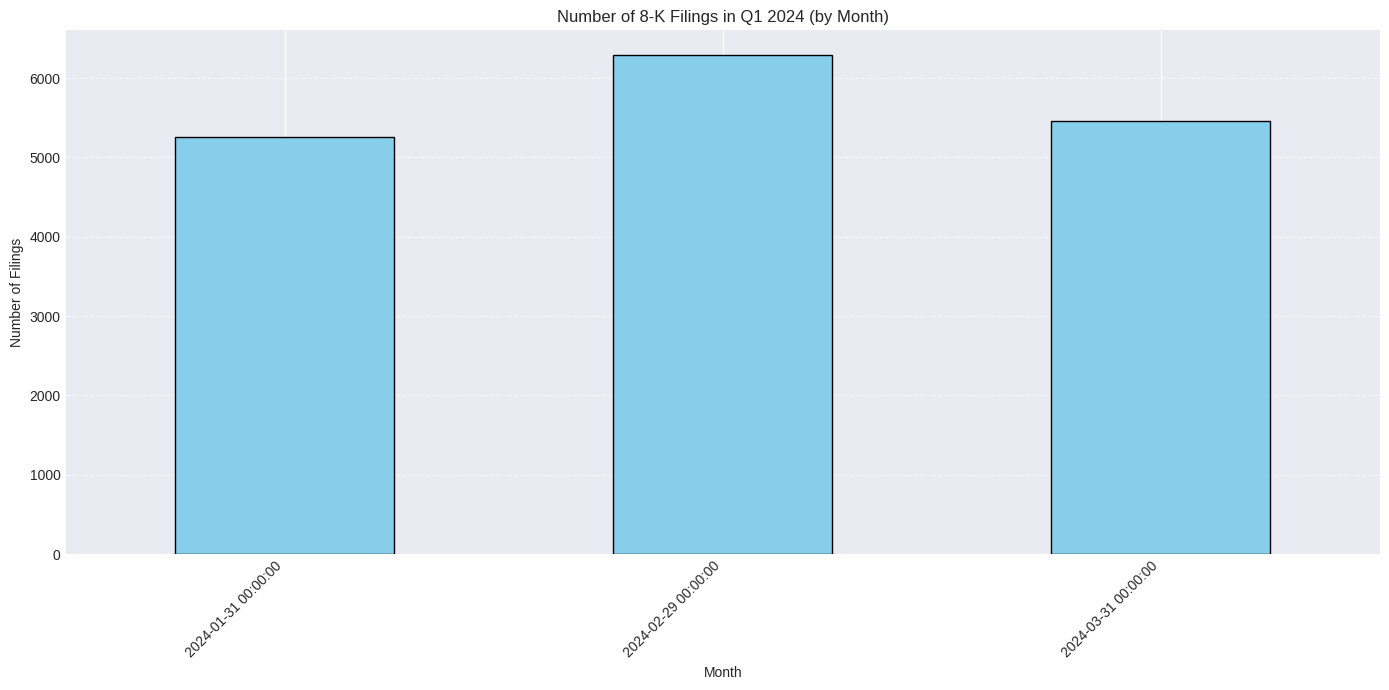

In [ ]:
if not filings_df.empty and 'filing_date' in filings_df.columns:
    # Ensure 'filing_date' is datetime type (already done, but good practice to check)
    if not pd.api.types.is_datetime64_any_dtype(filings_df['filing_date']):
         filings_df['filing_date'] = pd.to_datetime(filings_df['filing_date'], errors='coerce')

    # Drop rows where date conversion failed (resulting in NaT)
    filings_df_cleaned = filings_df.dropna(subset=['filing_date'])

    if not filings_df_cleaned.empty:
        # Set 'filing_date' as the index for resampling
        filings_df_cleaned = filings_df_cleaned.set_index('filing_date')

        # Resample by month end ('ME') and count the number of filings in each month
        filings_by_month = filings_df_cleaned.resample('ME').size()

        # Create the plot
        plt.figure(figsize=(14, 7))
        filings_by_month.plot(kind='bar', color='skyblue', edgecolor='black')  # Zmiana na wykres słupkowy
        plt.title(f'Number of {target_form_type} Filings in Q1 2024 (by Month)')
        plt.xlabel('Month')
        plt.ylabel('Number of Filings')
        plt.xticks(rotation=45, ha='right')  # Obrót etykiet osi X dla lepszej czytelności
        plt.ylim(bottom=0)
        plt.grid(True, axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()
    else:
        print("No valid filing date data available after cleaning.")

else:
    print("DataFrame is empty or missing 'filing_date' column. Skipping time series analysis.")

### 2.2. Distribution of Form Types

If we had fetched multiple form types (e.g., `form_type="10-K,8-K,10-Q"`), this would show their relative frequency. Since we only fetched `8-K`, the bar chart will only have one bar, but the code demonstrates the process.

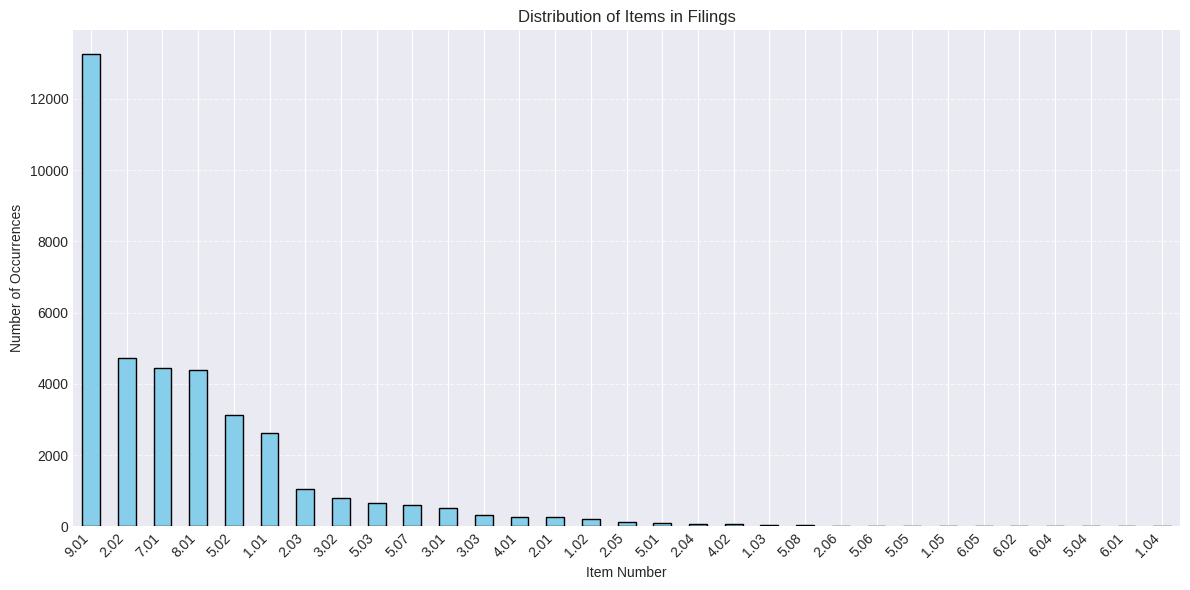

In [ ]:
if not filings_df.empty and 'items' in filings_df.columns:
    # 1. Extract and Explode Items
    all_items = filings_df['items'].str.split(',').explode()
    # 2. Count Occurrences
    item_counts = all_items.value_counts()

    # print("\nFiling Counts by Item:")
    # print(item_counts)

    # 3. Create Bar Chart
    plt.figure(figsize=(12, 6))  # Adjust size if needed
    item_counts.plot(kind='bar', color='skyblue', edgecolor='black')
    plt.title('Distribution of Items in Filings')
    plt.xlabel('Item Number')
    plt.ylabel('Number of Occurrences')
    plt.xticks(rotation=45, ha='right')  # Rotate for readability
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
else:
    print("DataFrame is empty or missing 'item' column. Skipping item analysis.")

### 2.3. Analysis of Filing Size (Optional)

We can examine the distribution of the `size` field (in bytes) provided in the metadata.

<Figure size 1200x600 with 0 Axes>

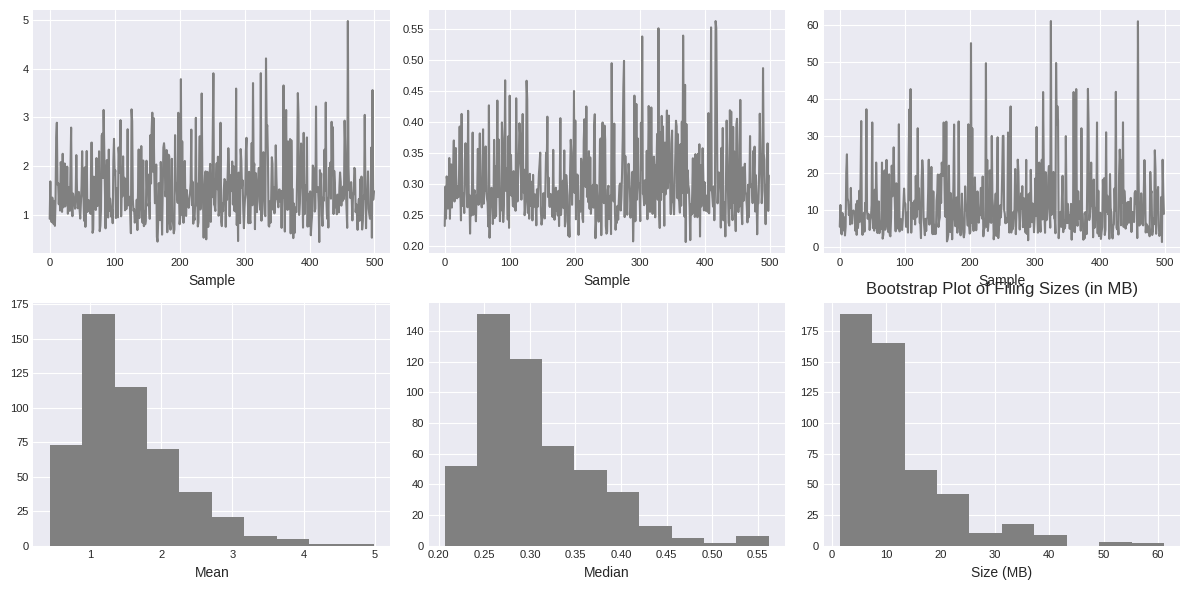


Descriptive Statistics for Filing Size (in bytes):
count         16,997
mean       1,635,512
std        5,318,228
min            2,549
25%          203,807
50%          301,055
75%          792,193
max      128,144,073
Name: size, dtype: object


In [ ]:
from pandas.plotting import bootstrap_plot

# ... (previous code) ...

if not filings_df.empty and 'size' in filings_df.columns:
    # Convert 'size' column to numeric, coercing errors to NaN, then drop NaNs
    sizes_bytes = pd.to_numeric(filings_df['size'], errors='coerce').dropna()

    if not sizes_bytes.empty:
        # Convert bytes to Megabytes (MB) for better readability
        sizes_mb = sizes_bytes / (1024 * 1024)

        # Create a Bootstrap plot
        plt.figure(figsize=(12, 6))
        bootstrap_plot(sizes_mb, size=50, samples=500, color="grey")
        plt.title('Bootstrap Plot of Filing Sizes (in MB)')
        plt.xlabel('Size (MB)')
        plt.show()

        print("\nDescriptive Statistics for Filing Size (in bytes):")
        # Show stats in bytes for precision, formatted nicely
        print(sizes_bytes.describe().apply(lambda x: f"{x:,.0f}"))
    else:
        print("No valid filing size data available after cleaning.")
else:
    print("DataFrame is empty or missing 'size' column. Skipping size analysis.")

## 3. Filing Content Extraction (`/v1/extractor` & `/v1/extractor/item`)

Your FinFeedAPI provides endpoints to extract the *content* of specific filings, identified by their `accession_number`.

* `/v1/extractor`: Retrieves the full filing content, intelligently classified into items (e.g., Item 1.01, Item 2.01 for 8-K; Item 1, Item 1A for 10-K/10-Q). Supports HTML and plain text filings.
* `/v1/extractor/item`: Retrieves only the text content of a *specific* item number within a filing.

**Example:** Let's take the `accession_number` of the first filing from our `filings_df` (if it exists) and fetch its structured content using `/v1/extractor`.

In [ ]:
if not filings_df.empty and 'accession_number' in filings_df.columns:
    # Check if the DataFrame has rows
    if len(filings_df) > 0:
        # Get the accession number from the first row
        example_accession_number = filings_df['accession_number'].iloc[1]
        print(f"\nAttempting to extract structure for filing: {example_accession_number}")

        # Fetch data
        api_instance2 = api_bricks_sec_api_rest.ContentExtractionApi(api_client)
        try:
          extracted_data = api_instance2.v1_extractor_get (
              accession_number = example_accession_number
          )

          # Process the extracted data
          if extracted_data is not None:
          # if extracted_data is not None and isinstance(extracted_data, dict):
          # if extracted_data and isinstance(extracted_data, dict):
              print(f"\nSuccessfully extracted data for {example_accession_number}.")
              print(f"Form Type: {extracted_data.form_type}")

              # Check if 'items' exist and is a list
              # if 'items' in extracted_data and isinstance(extracted_data['items'], list):
              print(f"Found {len(extracted_data.items)} items.")
              print("\nDisplaying first 2 items (if available):")
              # Display details of the first few items for brevity
              for item in extracted_data.items[:2]:
                  print("-" * 20)
                  print(f"  Item Number: {item.item_number}")
                  print(f"  Item Title: {item.item_title}")
                  # Show only a preview of the content
                  content_preview = item.content
                  print(f"  Content Preview: {content_preview[:250]}...") # Show first 250 chars
              print("-" * 20)

              # --- Example usage of /v1/extractor/item ---
              # Let's try to get the content of the *first* item found above
              if len(extracted_data.items) > 0:
                  first_item = extracted_data.items[0]
                  example_item_number = first_item.item_number

                  if example_item_number:
                      print(f"\nAttempting to extract content specifically for Item: '{example_item_number}'")
                      item_content = api_instance2.v1_extractor_item_get(accession_number = example_accession_number,
                                                                         item_number = example_item_number)

                      if item_content is not None: # Check if fetch was successful
                          print(f"\nExtracted Content for Item '{example_item_number}' (first 500 characters):")
                          # The response itself is the string content
                          print(item_content[:500] + ('...' if len(item_content) > 500 else ''))
                      else:
                          print(f"Failed to fetch specific content for Item '{example_item_number}'.")
                  else:
                        print("\nCould not determine the item number of the first item to fetch its specific content.")
        except ApiException as e:
            print("Exception when calling ContentExtractionApi->v1_extractor_get: %s\n" % e)
    else:
        # Handle case where the DataFrame was empty
        print("\nDataFrame is empty. Cannot select an accession number for extraction.")
else:
    # Handle case where DataFrame is missing the required column
    print("\nDataFrame is empty or missing 'accession_number' column. Skipping content extraction example.")


Attempting to extract structure for filing: 0001104659-24-023011

Successfully extracted data for 0001104659-24-023011.
Form Type: 8-K
Found 2 items.

Displaying first 2 items (if available):
--------------------
  Item Number: 801
  Item Title: Other Events
  Content Preview: Information Related to the Transactions Supplementary Risk Factors Certain information with respect to material risks related to the Transactions, which supplements the risk factors described in the Company’s Annual Report on Form 10-K for the fiscal...
--------------------
  Item Number: 901
  Item Title: Financial Statements and Exhibits
  Content Preview: (a) Financial statements of business to be acquired. The combined financial statements of the Triumph Group Product Support Business as of and for the year ended March 31, 2023, attached as Exhibit 99.3 hereto and incorporated by reference herein, ha...
--------------------

Attempting to extract content specifically for Item: '801'

Extracted Content for It

## 4. Full-Text Search (`/v1/full-text`)

The `/v1/full-text` endpoint allows searching *within* the text content of SEC filing documents. It supports filtering by:

* `form_type`
* `filling_date_start` / `filling_date_end`
* `text_contains`: Keywords that *must* appear (comma-separated for AND logic, space might imply OR - check API docs if needed)
* `text_not_contain`: Keywords that *must not* appear
* Pagination (`page_size`, `page_number`)
* Sorting (`sort_by`, `sort_order`) - fields include `CompanyName`, `CIK`, etc.

**Example:** Let's find up to 10 Form 10-K filings from 2025 that mention "artificial intelligence" but do *not* mention "layoffs".

In [ ]:
print("\nPerforming full-text search...")

api_instance3 = api_bricks_sec_api_rest.FullTextSearchApi(api_client)
try:
  search_results = api_instance3.v1_full_text_get(
    form_type = "10-K",
    filling_date_start = "2025-01-01",
    filling_date_end = "2025-12-31",
    text_contains = "artificial intelligence", # Keyword(s) that must be present
    text_not_contain = "layoffs",             # Keyword(s) to exclude
    page_size = 10,                           # Limit results for this example
    page_number = 1,
    # sort_by = "FilingDate",                   # Sort results by filing date
    # sort_order = "desc"                       # Show most recent first
  )

  # Process the search results
  if search_results is not None and isinstance(search_results, list):
      print(f"Found {len(search_results)} filings matching the full-text search criteria.")
      if len(search_results) > 0:
          # Convert results to DataFrame for display
          search_df = pd.DataFrame.from_records([vars(x) for x in search_results])
          print("\nFull-Text Search Results Sample:")
          # Display relevant columns
          display(search_df[['filing_date', 'cik', 'company_name', 'form_type', 'accession_number']].head())
  elif search_results == []:
      print("Full-text search returned no results matching the criteria.")
  else:
      print("Full-text search failed or returned an unexpected format.")
except ApiException as e:
    print("Exception when calling FilingMetadataApi->v1_filings_get: %s\n" % e)


Performing full-text search...
Found 10 filings matching the full-text search criteria.

Full-Text Search Results Sample:


,filing_date,cik,company_name,form_type,accession_number
0,2025-02-05,2488,ADVANCED,10-K,0000002488-25-000012
1,2025-02-05,2488,ADVANCED,10-K,0000002488-25-000012
2,2025-02-05,2488,ADVANCED,10-K,0000002488-25-000012
3,2025-02-05,2488,ADVANCED,10-K,0000002488-25-000012
4,2025-02-14,4281,Howmet,10-K,0000004281-25-000011


## Conclusion

This notebook demonstrated how to leverage the FinFeedAPI (provided by API BRICKS LTD) to programmatically access and analyze SEC EDGAR filing data. We covered:

* Fetching filing metadata using `/v1/filings` with filtering, pagination, and sorting.
* Performing basic time series and distribution analysis on the metadata using pandas and matplotlib.
* Extracting structured content and specific items from filings using `/v1/extractor` and `/v1/extractor/item`.
* Conducting targeted searches within filing documents using the `/v1/full-text` endpoint.

**Further Analysis Possibilities:**

* **Comprehensive Historical Analysis:** Implement the pagination logic outlined earlier to fetch data spanning multiple years and analyze long-term trends in filing frequency, form types, or sizes.
* **Company-Specific Analysis:** Filter filings by `cik` to track the reporting activities of specific companies.
* **Industry Trends:** Group companies by industry code (if available through another source or inferred) and compare filing patterns across sectors.
* **Natural Language Processing (NLP):** Apply NLP techniques to the content extracted via `/v1/extractor` or `/v1/extractor/item`. This could include sentiment analysis (e.g., on "Risk Factors" - Item 1A in 10-Ks), topic modeling, or entity recognition.
* **Correlation Analysis:** Combine filing data (e.g., frequency of certain keywords, timing of 8-Ks) with financial market data (stock prices, trading volume) to explore potential relationships.

Remember to consult the specific documentation for the FinFeedAPI for details on rate limits, potential costs, and the exact behavior of search parameters (e.g., how multiple keywords in `text_contains` are handled - AND vs. OR). Always handle your API key securely.